<a href="https://colab.research.google.com/github/straxFromIbr/UnetModelScript/blob/main/home/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Mon Dec 13 11:13:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    36W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
% cd /content
from google.colab import drive
drive.mount('/content/drive')
! unzip /content/drive/MyDrive/卒研/mass_roadsのコピー.zip &>/dev/null
! git clone --depth 1 https://github.com/straxFromIbr/UnetModelScript/
% cd /content/UnetModelScript/home
! pip install tensorflow-addons scikit-image &>/dev/null  

/content
Mounted at /content/drive
Cloning into 'UnetModelScript'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 28 (delta 0), reused 11 (delta 0), pack-reused 0
Unpacking objects: 100% (28/28), done.
/content/UnetModelScript/home


In [3]:
import random
import os
import pathlib
import math

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage import io as skio
from skimage import transform, morphology

import train
import config
from model import losses
from train import mkds, compile_model
from dataset_utils import preprocess, auguments


In [4]:
BATCH_SIZE = 64

ds_root = pathlib.Path("/content/mass_roadsのコピー/train/")
pathlist = ds_root.glob("map/*.png")
pathlist = sorted([path.name for path in pathlist])
random.shuffle(pathlist)

In [5]:
nb_tr = int(len(pathlist) * 0.8)
tr_pathlist = pathlist[:nb_tr]

steps_per_epoch = math.ceil(nb_tr / BATCH_SIZE)
tr_sat_pathlist = sorted([str(ds_root / "sat" / path) for path in tr_pathlist])
tr_map_pathlist = sorted([str(ds_root / "map" / path) for path in tr_pathlist])
train_ds = mkds(
    tr_sat_pathlist, tr_map_pathlist, batch_size=BATCH_SIZE, 
    aug=True, zoom=False, rotate=True, flip=True
)

In [6]:
nb_va = int(len(pathlist) * 0.2)
va_pathlist = pathlist[nb_tr: nb_tr + nb_va]

va_steps = math.ceil(nb_va / BATCH_SIZE)
va_sat_pathlist = sorted([str(ds_root / "sat" / path) for path in va_pathlist])
va_map_pathlist = sorted([str(ds_root / "map" / path) for path in va_pathlist])
valid_ds = mkds(va_sat_pathlist, va_map_pathlist, batch_size=BATCH_SIZE, test=True) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


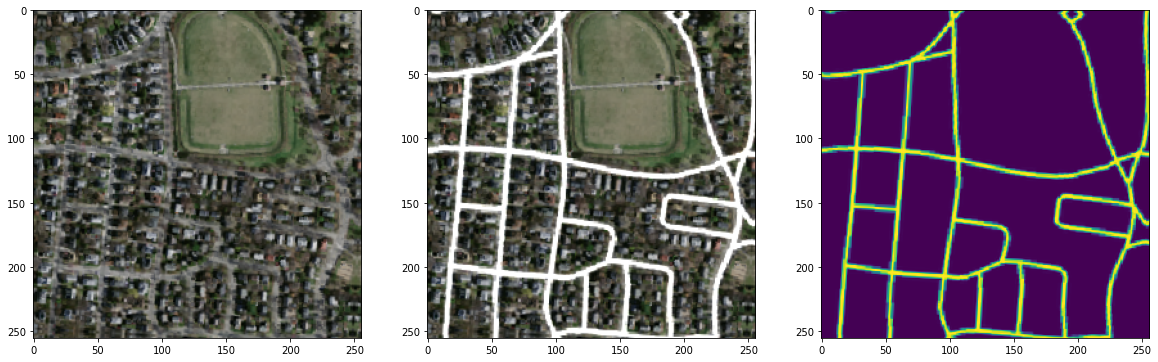

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


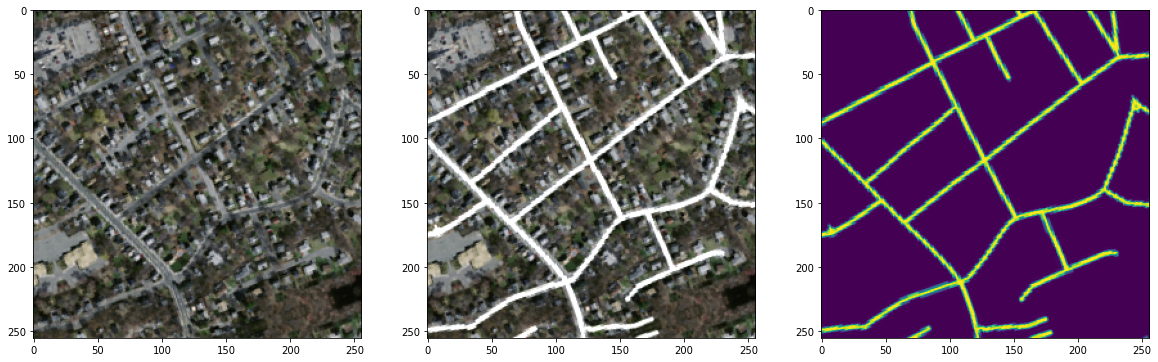

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


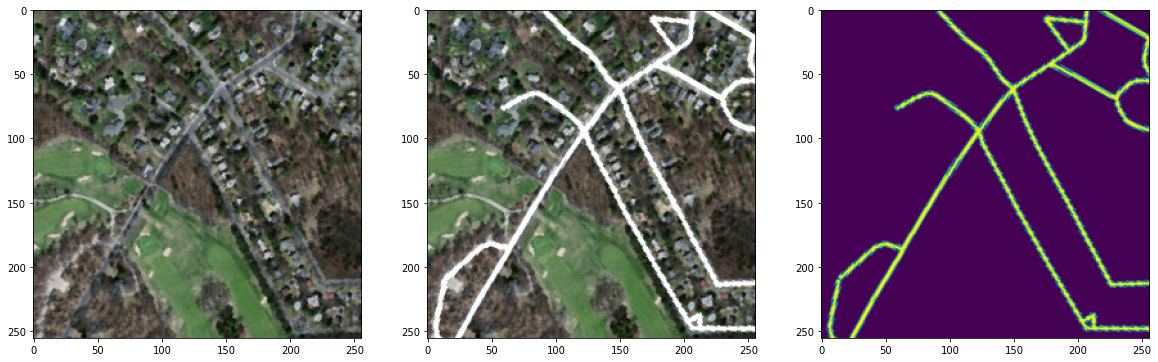

In [8]:
for i, t in train_ds.take(3):
    idx = 3
    plt.figure(figsize=(20, 20))
    plt.subplot(1, 3, 1)
    plt.imshow(i[idx])
    plt.subplot(1, 3, 2)
    plt.imshow(t[idx] + i[idx])
    plt.subplot(1, 3, 3)
    plt.imshow(t[idx][..., 0])
    plt.show()

In [ ]:
loss = losses.DICELoss(name="DICE")
model = compile_model(loss=loss)
steps_per_epoch = math.ceil(nb_tr / config.BATCH_SIZE)
va_steps = math.ceil(nb_va / config.BUFFER_SIZE)
## 訓練
filename = "augument_test"
model_history = model.fit(
    train_ds,
    epochs=20,
    validation_data=valid_ds,
    steps_per_epoch=steps_per_epoch,
    validation_steps=va_steps,
    # callbacks=get_callbacks(filename),
)


Epoch 1/20
108/108 [==============================] - 134s 1s/step - loss: 0.7956 - mean_io_u: 0.4974 - val_loss: 0.9416 - val_mean_io_u: 0.4886
Epoch 2/20
108/108 [==============================] - 115s 1s/step - loss: 0.5322 - mean_io_u: 0.5176 - val_loss: 0.9936 - val_mean_io_u: 0.4886
Epoch 3/20
108/108 [==============================] - 114s 1s/step - loss: 0.4657 - mean_io_u: 0.5335 - val_loss: 0.9962 - val_mean_io_u: 0.4886
Epoch 4/20
108/108 [==============================] - 115s 1s/step - loss: 0.4447 - mean_io_u: 0.5394 - val_loss: 0.5518 - val_mean_io_u: 0.5192
Epoch 5/20
108/108 [==============================] - 117s 1s/step - loss: 0.4243 - mean_io_u: 0.5426 - val_loss: 0.4974 - val_mean_io_u: 0.5450
Epoch 6/20
108/108 [==============================] - 115s 1s/step - loss: 0.4153 - mean_io_u: 0.5433 - val_loss: 0.4399 - val_mean_io_u: 0.5765
Epoch 7/20
108/108 [==============================] - 115s 1s/step - loss: 0.4085 - mean_io_u: 0.5440 - val_loss: 0.4994 - val_mea

In [ ]:
print(model_history.history.keys())
tr_loss = model_history.history["loss"]
va_loss = model_history.history["val_loss"]
tr_iou = model_history.history["mean_io_u"]
va_iou = model_history.history["val_mean_io_u"]

plt.figure()
plt.title("mean IoU")
plt.plot(tr_iou, "r")
plt.plot(va_iou, "bo")
plt.show()

plt.title("loss")
plt.plot(tr_loss, "r")
plt.plot(va_loss, "bo")
plt.show()


In [ ]:
for i,t in valid_ds.take(3):
    pred = model.predict(i)
    plt.imshow(i[0])
    plt.show()
    plt.imshow(t[0])
    plt.show()
    plt.imshow(pred[0])
    plt.show()